In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
# --- 1. Tải và chuẩn bị dữ liệu ---

# Tải dữ liệu
data = pd.read_csv('HOSEVN1001D.csv')

# Chúng ta sẽ dự đoán giá 'close'
# Chuyển cột 'time' sang datetime (mặc dù không dùng để train nhưng tốt cho việc lọc)
data['time'] = pd.to_datetime(data['time'], unit='s')

# Sắp xếp lại theo thời gian
data = data.sort_values('time')

# Xử lý các giá trị NaN (nếu có)
# Một cách đơn giản là xóa các hàng có NaN
data = data.dropna(subset=['close'])

# Lấy dữ liệu giá 'close'
close_data = data.filter(['close'])
dataset = close_data.values

# Chuẩn hóa dữ liệu về khoảng (0, 1) vì LSTM hoạt động tốt nhất với dữ liệu đã chuẩn hóa
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [5]:
# --- 2. Tạo chuỗi dữ liệu (sequences) ---

# Chúng ta sẽ dùng 60 ngày dữ liệu quá khứ để dự đoán ngày tiếp theo
SEQUENCE_LENGTH = 60

# Tách dữ liệu thành training (80%) và testing (20%)
training_data_len = int(np.ceil(len(dataset) * .8))

train_data = scaled_data[0:int(training_data_len), :]

# Tạo dữ liệu training
x_train = []
y_train = []

for i in range(SEQUENCE_LENGTH, len(train_data)):
    x_train.append(train_data[i-SEQUENCE_LENGTH:i, 0])
    y_train.append(train_data[i, 0])

# Chuyển sang numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape dữ liệu cho mô hình LSTM [samples, time_steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
# --- 3. Xây dựng mô hình LSTM (>= 5 Lớp) ---

model = Sequential()

# Layer 1: LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Layer 2: Dropout (để tránh overfitting)
model.add(Dropout(0.2))

# Layer 3: LSTM layer
model.add(LSTM(units=50, return_sequences=True))
# Layer 4: Dropout
model.add(Dropout(0.2))

# Layer 5: LSTM layer
model.add(LSTM(units=50, return_sequences=False)) # return_sequences=False vì layer tiếp theo là Dense
# Layer 6: Dense layer
model.add(Dense(units=25))

# Layer 7: Output layer
model.add(Dense(units=1))

# In cấu trúc mô hình để kiểm tra
print("Cấu trúc mô hình:")
model.summary()

Cấu trúc mô hình:


C:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# --- 4. Compile và Train mô hình ---

# Compile mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Train mô hình
# (Bạn có thể tăng/giảm epochs hoặc batch_size để có kết quả tốt hơn)
print("\nBắt đầu huấn luyện mô hình...")
model.fit(x_train, y_train, batch_size=32, epochs=10)
print("Huấn luyện hoàn tất!")


Bắt đầu huấn luyện mô hình...
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0106
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0010
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.3430e-04
Huấn luyện hoàn tất!


In [8]:
# --- 5. Chuẩn bị dữ liệu Test và Đánh giá ---

# Tạo dữ liệu test
test_data = scaled_data[training_data_len - SEQUENCE_LENGTH:, :]

x_test = []
y_test = dataset[training_data_len:, :] # y_test là giá trị thực (chưa scale)

for i in range(SEQUENCE_LENGTH, len(test_data)):
    x_test.append(test_data[i-SEQUENCE_LENGTH:i, 0])

# Chuyển sang numpy array
x_test = np.array(x_test)

# Reshape dữ liệu
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Root Mean Squared Error (RMSE): 32.57675319307342


C:\Users\Admin\AppData\Local\Temp\ipykernel_20768\2501325717.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


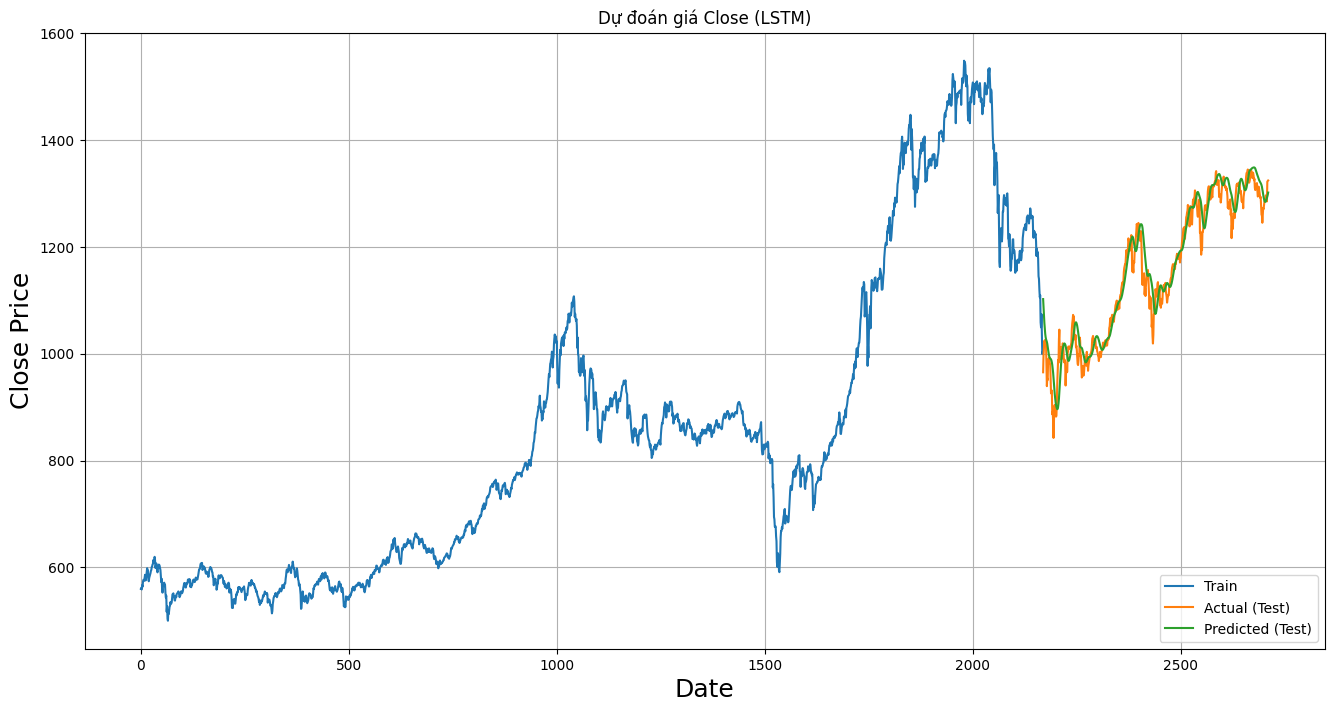

<Figure size 640x480 with 0 Axes>

In [10]:
# --- 6. Dự đoán và Trực quan hóa ---

# Lấy giá dự đoán
predictions = model.predict(x_test)
# Đảo ngược quá trình scale để lấy giá trị thực
predictions = scaler.inverse_transform(predictions)

# Tính lỗi RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'\nRoot Mean Squared Error (RMSE): {rmse}')

# Trực quan hóa kết quả
train = close_data[:training_data_len]
valid = close_data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Dự đoán giá Close (LSTM)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Actual (Test)', 'Predicted (Test)'], loc='lower right')
plt.grid(True)
plt.show()

# Lưu biểu đồ (tùy chọn)
plt.savefig('lstm_prediction_plot.png')

Số lượng mẫu train: 2109
Số lượng mẫu test: 542

--- Bắt đầu huấn luyện mô hình LSTM ---


C:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Huấn luyện LSTM hoàn tất!

--- Bắt đầu huấn luyện các mô hình Baseline ---
Huấn luyện Linear Regression hoàn tất.

--- Đang lấy kết quả dự đoán ---
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

--- KẾT QUẢ ĐÁNH GIÁ (RMSE) ---
Mô hình LSTM (7 lớp)     : 33.1110
Mô hình Linear Regression : 14.2340
Mô hình SMA (60 ngày)     : 67.8044
Mô hình Naive Forecast    : 13.8394
---------------------------------
(RMSE càng thấp, mô hình càng chính xác)


C:\Users\Admin\AppData\Local\Temp\ipykernel_20768\3650607426.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['LSTM'] = pred_lstm
C:\Users\Admin\AppData\Local\Temp\ipykernel_20768\3650607426.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Linear_Reg'] = pred_lr
C:\Users\Admin\AppData\Local\Temp\ipykernel_20768\3650607426.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

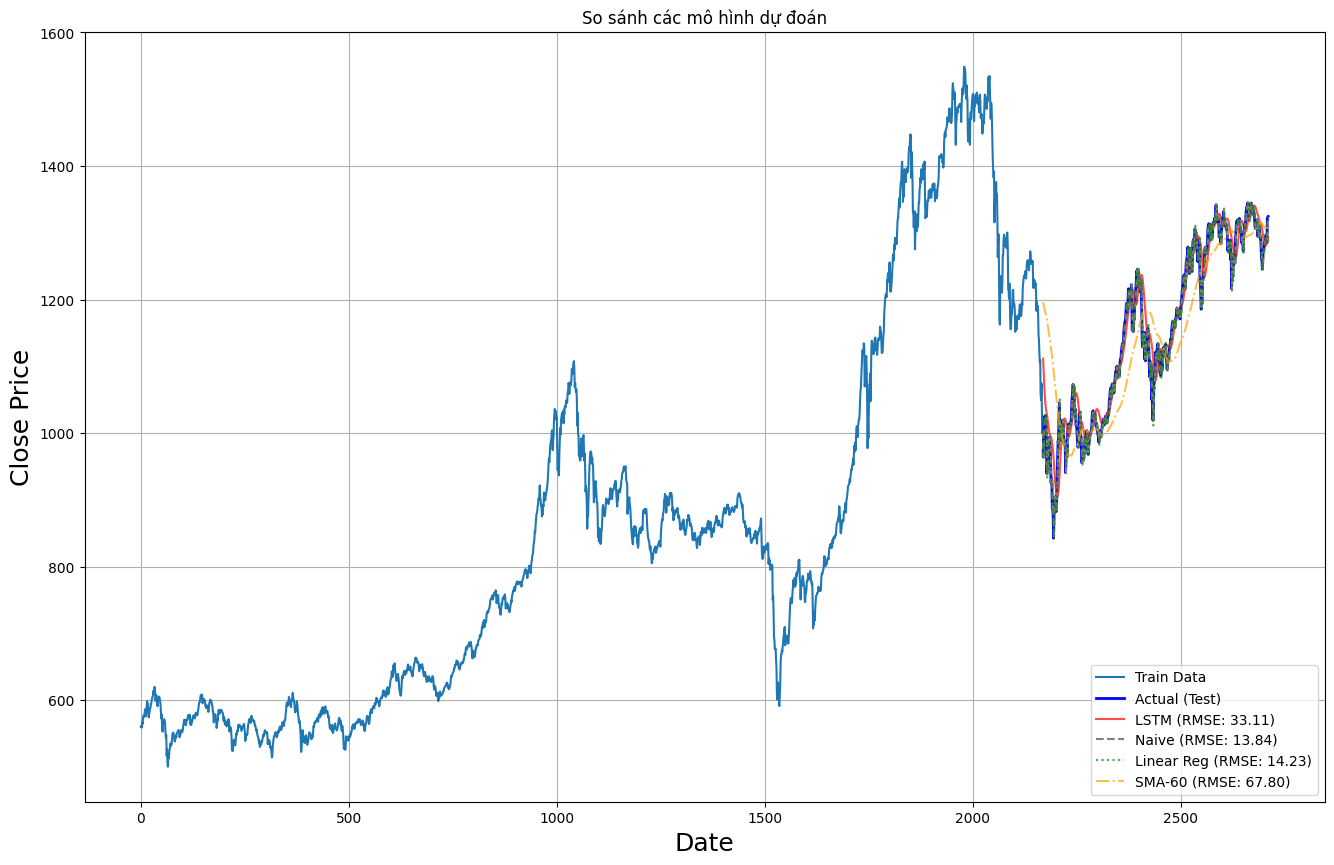

<Figure size 640x480 with 0 Axes>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- 1. Tải và chuẩn bị dữ liệu (Giữ nguyên) ---

data = pd.read_csv('HOSEVN1001D.csv')
data['time'] = pd.to_datetime(data['time'], unit='s')
data = data.sort_values('time')
data = data.dropna(subset=['close'])

close_data = data.filter(['close'])
dataset = close_data.values # Dữ liệu 'close' chưa scale (dùng cho baseline)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# --- 2. Tạo chuỗi dữ liệu (Giữ nguyên) ---

SEQUENCE_LENGTH = 60
training_data_len = int(np.ceil(len(dataset) * .8))
train_data = scaled_data[0:int(training_data_len), :]

# Tạo dữ liệu training cho LSTM và LR
x_train = []
y_train = [] # y_train đã được scale

for i in range(SEQUENCE_LENGTH, len(train_data)):
    x_train.append(train_data[i-SEQUENCE_LENGTH:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train_lstm = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Chuẩn bị dữ liệu test cho LSTM
test_data = scaled_data[training_data_len - SEQUENCE_LENGTH:, :]
x_test = []
y_test_actual = dataset[training_data_len:, :] # y_test thực tế (chưa scale)

for i in range(SEQUENCE_LENGTH, len(test_data)):
    x_test.append(test_data[i-SEQUENCE_LENGTH:i, 0])
    
x_test = np.array(x_test)
x_test_lstm = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

print(f"Số lượng mẫu train: {len(x_train)}")
print(f"Số lượng mẫu test: {len(y_test_actual)}")

# --- 3. Xây dựng mô hình LSTM (Giữ nguyên) ---

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_lstm.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))

# --- 4. Compile và Train mô hình LSTM (Giữ nguyên) ---

print("\n--- Bắt đầu huấn luyện mô hình LSTM ---")
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(x_train_lstm, y_train, batch_size=32, epochs=10, verbose=0) # verbose=0 để bớt log
print("Huấn luyện LSTM hoàn tất!")

# --- 5. Huấn luyện các mô hình Baseline ---

print("\n--- Bắt đầu huấn luyện các mô hình Baseline ---")

# Baseline 1: Linear Regression
# Dữ liệu x_train/x_test cần ở dạng 2D (samples, features)
x_train_lr = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
x_test_lr = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

model_lr = LinearRegression()
model_lr.fit(x_train_lr, y_train) # Train trên dữ liệu đã scale
print("Huấn luyện Linear Regression hoàn tất.")

# Baseline 2: Naive Forecast (Không cần huấn luyện)
# Baseline 3: SMA (Không cần huấn luyện)

# --- 6. Lấy kết quả dự đoán từ tất cả mô hình ---

print("\n--- Đang lấy kết quả dự đoán ---")

# Dự đoán của LSTM
pred_lstm_scaled = model_lstm.predict(x_test_lstm)
pred_lstm = scaler.inverse_transform(pred_lstm_scaled)

# Dự đoán của Linear Regression
pred_lr_scaled = model_lr.predict(x_test_lr)
pred_lr = scaler.inverse_transform(pred_lr_scaled.reshape(-1, 1))

# Dự đoán của Naive Forecast
# Giá trị dự đoán là giá trị của ngày hôm trước
pred_naive = dataset[training_data_len - 1 : len(dataset) - 1, :]

# Dự đoán của SMA
pred_sma = []
for i in range(training_data_len, len(dataset)):
    # Lấy 60 ngày trước đó
    window = dataset[i - SEQUENCE_LENGTH : i, 0]
    sma = np.mean(window)
    pred_sma.append(sma)

pred_sma = np.array(pred_sma).reshape(-1, 1)

# --- 7. Đánh giá và So sánh ---

print("\n--- KẾT QUẢ ĐÁNH GIÁ (RMSE) ---")

# y_test_actual là giá trị thực
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, pred_lstm))
rmse_lr = np.sqrt(mean_squared_error(y_test_actual, pred_lr))
rmse_naive = np.sqrt(mean_squared_error(y_test_actual, pred_naive))
rmse_sma = np.sqrt(mean_squared_error(y_test_actual, pred_sma))

print(f"Mô hình LSTM (7 lớp)     : {rmse_lstm:.4f}")
print(f"Mô hình Linear Regression : {rmse_lr:.4f}")
print(f"Mô hình SMA (60 ngày)     : {rmse_sma:.4f}")
print(f"Mô hình Naive Forecast    : {rmse_naive:.4f}")
print("---------------------------------")
print("(RMSE càng thấp, mô hình càng chính xác)")

# --- 8. Trực quan hóa so sánh ---

valid = close_data[training_data_len:]
valid['LSTM'] = pred_lstm
valid['Linear_Reg'] = pred_lr
valid['SMA'] = pred_sma
valid['Naive'] = pred_naive

plt.figure(figsize=(16,10))
plt.title('So sánh các mô hình dự đoán')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(close_data[:training_data_len]['close'], label='Train Data') # Dữ liệu train
plt.plot(valid['close'], label='Actual (Test)', color='blue', linewidth=2) # Dữ liệu thực tế
plt.plot(valid['LSTM'], label=f'LSTM (RMSE: {rmse_lstm:.2f})', color='red', alpha=0.7)
plt.plot(valid['Naive'], label=f'Naive (RMSE: {rmse_naive:.2f})', color='gray', linestyle='--')
plt.plot(valid['Linear_Reg'], label=f'Linear Reg (RMSE: {rmse_lr:.2f})', color='green', linestyle=':', alpha=0.7)
plt.plot(valid['SMA'], label=f'SMA-60 (RMSE: {rmse_sma:.2f})', color='orange', linestyle='-.', alpha=0.7)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Lưu biểu đồ (tùy chọn)
plt.savefig('model_comparison_plot.png')

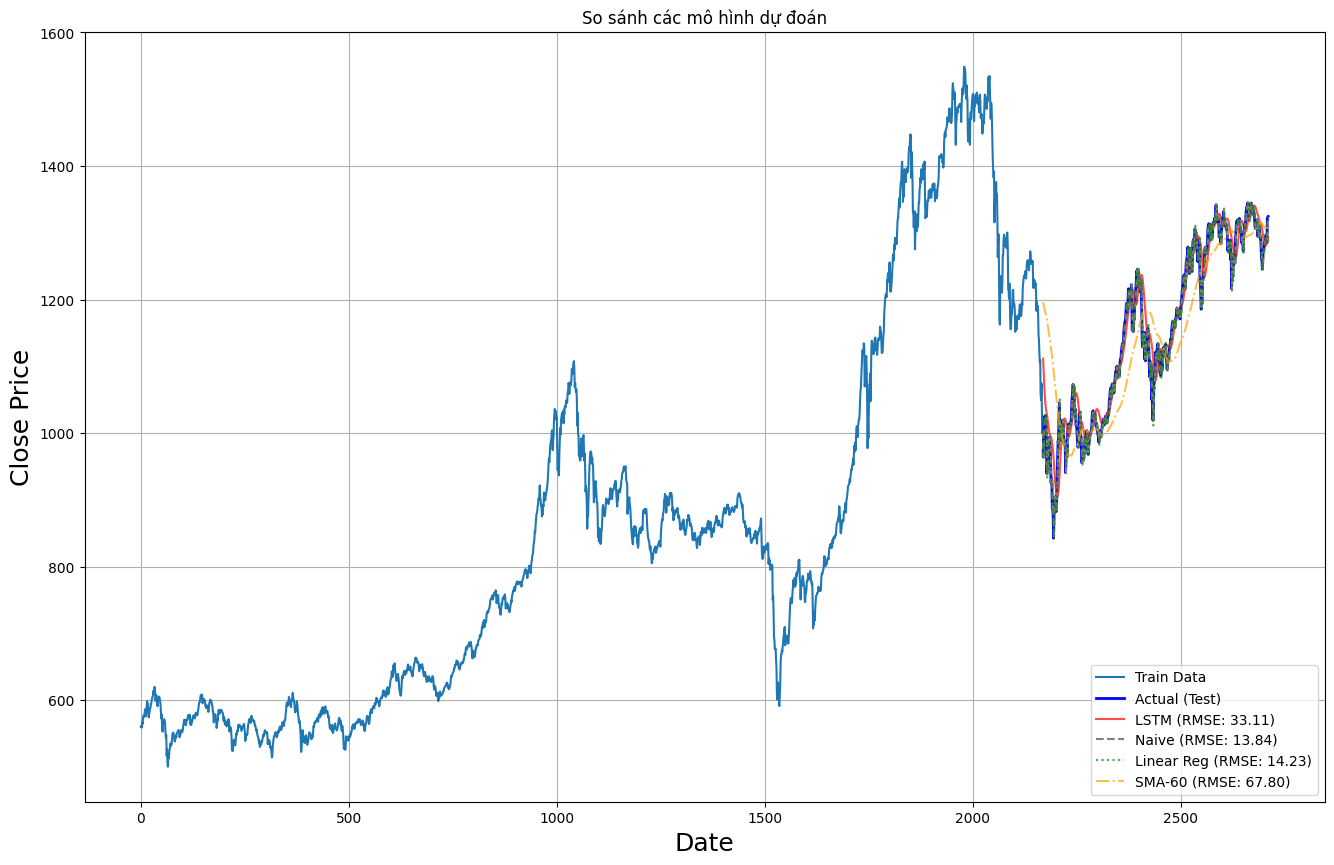

<Figure size 640x480 with 0 Axes>

In [12]:
# --- 8. Trực quan hóa so sánh (Đã sửa) ---

# Tạo một bản sao (copy) rõ ràng để tránh SettingWithCopyWarning
valid = close_data[training_data_len:].copy() 

# Bây giờ gán các cột mới vào bản sao này
valid['LSTM'] = pred_lstm
valid['Linear_Reg'] = pred_lr
valid['SMA'] = pred_sma
valid['Naive'] = pred_naive

plt.figure(figsize=(16,10))
plt.title('So sánh các mô hình dự đoán')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(close_data[:training_data_len]['close'], label='Train Data') # Dữ liệu train
plt.plot(valid['close'], label='Actual (Test)', color='blue', linewidth=2) # Dữ liệu thực tế
plt.plot(valid['LSTM'], label=f'LSTM (RMSE: {rmse_lstm:.2f})', color='red', alpha=0.7)
plt.plot(valid['Naive'], label=f'Naive (RMSE: {rmse_naive:.2f})', color='gray', linestyle='--')
plt.plot(valid['Linear_Reg'], label=f'Linear Reg (RMSE: {rmse_lr:.2f})', color='green', linestyle=':', alpha=0.7)
plt.plot(valid['SMA'], label=f'SMA-60 (RMSE: {rmse_sma:.2f})', color='orange', linestyle='-.', alpha=0.7)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Lưu biểu đồ (tùy chọn)
plt.savefig('model_comparison_plot.png')

In [13]:
import numpy as np

# --- 1. Lấy 60 ngày dữ liệu cuối cùng (dùng để dự đoán ngày tiếp theo) ---
# Chúng ta dùng 'dataset' (giá close thực tế, chưa scale)
last_60_days_data = dataset[-SEQUENCE_LENGTH:]

# --- 2. Chuẩn hóa (Scale) 60 ngày này ---
# Lưu ý: Chúng ta dùng scaler ĐÃ FIT từ trước, KHÔNG fit_transform lại
last_60_days_scaled = scaler.transform(last_60_days_data)

# --- 3. Tạo 1 mẫu test (X_input) ---
X_input = []
X_input.append(last_60_days_scaled) # Đây là chuỗi 60 ngày đã scale
X_input = np.array(X_input)

# --- 4. Reshape lại cho mô hình LSTM (samples, time_steps, features) ---
X_input = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))

# --- 5. Lấy dự đoán (dạng đã scale) ---
predicted_price_scaled = model_lstm.predict(X_input)

# --- 6. Đảo ngược scale (Inverse Transform) để ra giá trị thực ---
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# --- 7. Lấy giá thực tế của ngày cuối cùng ---
last_actual_price = last_60_days_data[-1][0] # Lấy giá 'close' của ngày cuối cùng

# --- 8. In kết quả và dự đoán Lên/Xuống ---
print("\n--- DỰ BÁO CHO NGÀY TIẾP THEO ---")
print(f"Giá đóng cửa hôm nay (ngày cuối): {last_actual_price:.2f}")
print(f"Giá dự đoán cho ngày mai: {predicted_price[0][0]:.2f}")

if predicted_price[0][0] > last_actual_price:
    print("Dự đoán xu hướng: TĂNG (UP)")
else:
    print("Dự đoán xu hướng: GIẢM (DOWN)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

--- DỰ BÁO CHO NGÀY TIẾP THEO ---
Giá đóng cửa hôm nay (ngày cuối): 1324.48
Giá dự đoán cho ngày mai: 1297.47
Dự đoán xu hướng: GIẢM (DOWN)


Đang tải và xử lý dữ liệu...
Đã tải và xử lý 2711 hàng dữ liệu thô.
------------------------------
Đang vẽ Biểu đồ 1: Giá Close theo thời gian...
Đã lưu chart_1_close_price.png
Đang vẽ Biểu đồ 2: Giá Close và các đường EMA...
Đã lưu chart_2_emas.png
Đang vẽ Biểu đồ 3: Phân phối Tỷ suất sinh lợi hàng ngày...
Đã lưu chart_3_returns_histogram.png
Đang vẽ Biểu đồ 4: Biến động giá trong ngày (High - Low)...
Đã lưu chart_4_daily_spread.png
Đang vẽ Biểu đồ 5: Phân phối giá Close theo Năm...
Đã lưu chart_5_box_plot_year.png
------------------------------
Hoàn tất! 5 biểu đồ đã được lưu vào thư mục của bạn.


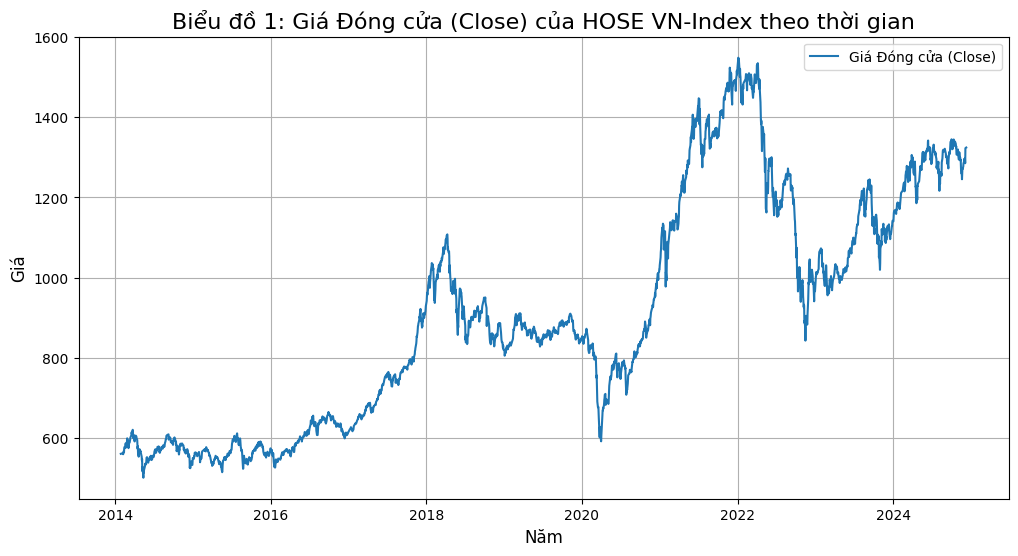

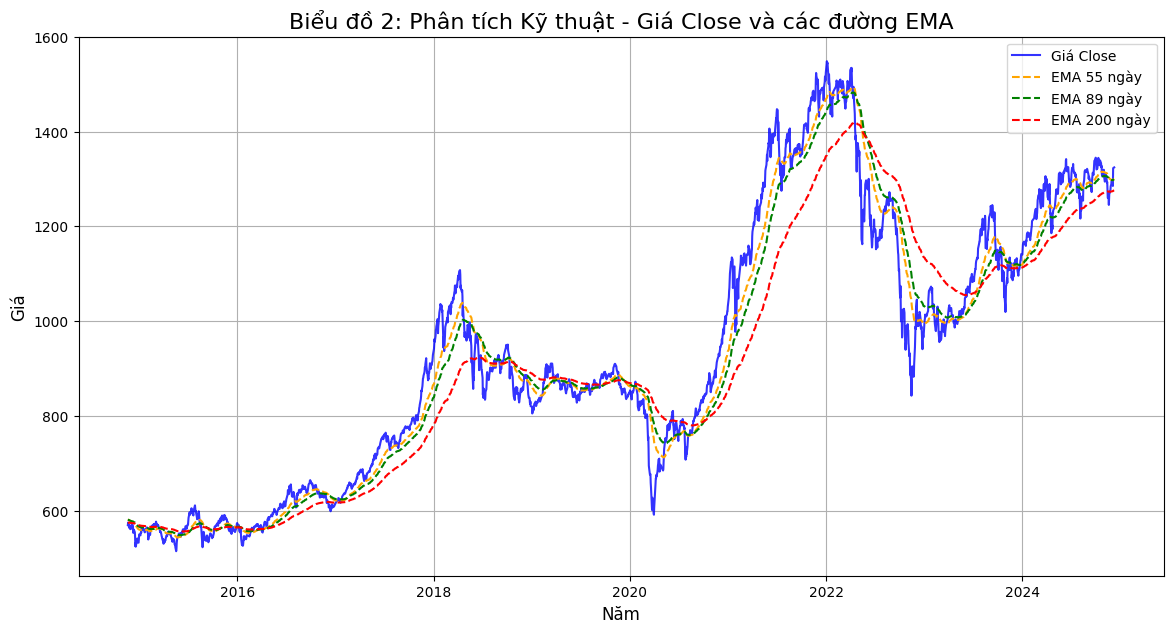

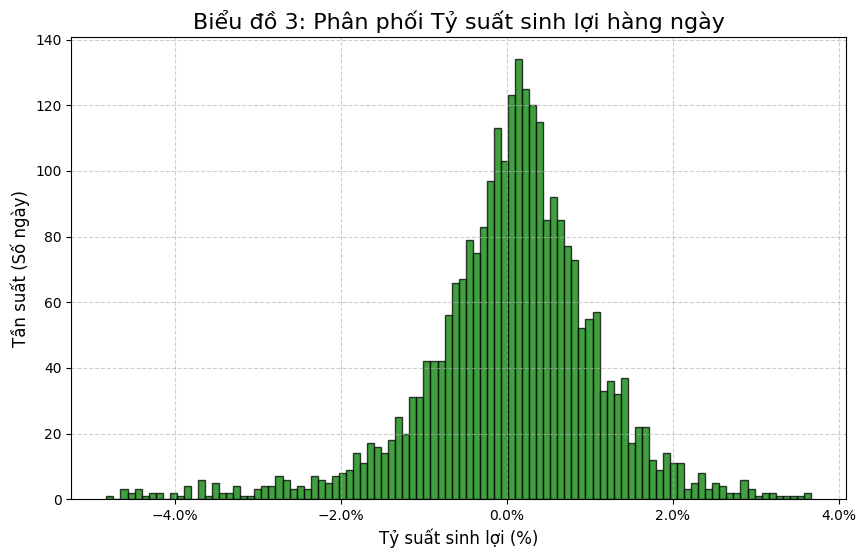

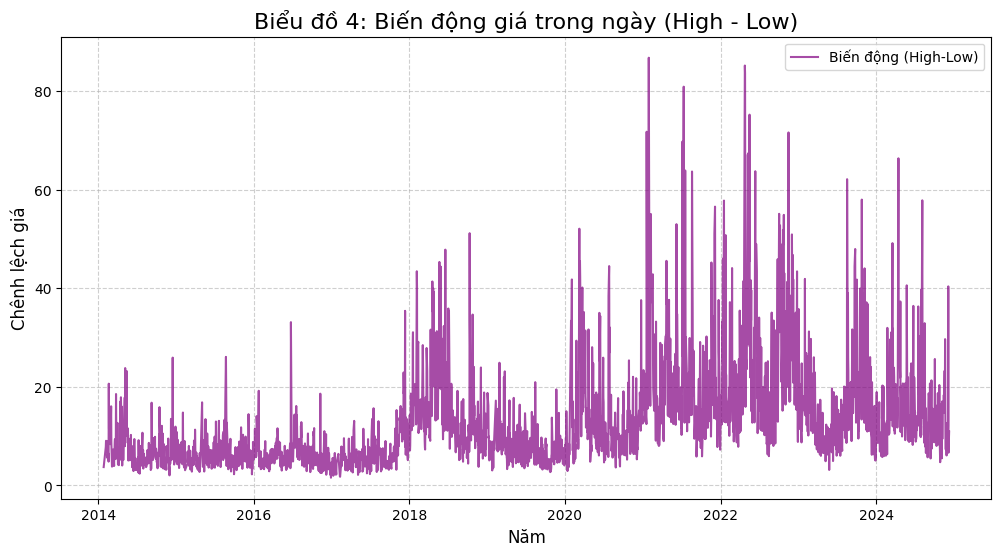

<Figure size 1200x700 with 0 Axes>

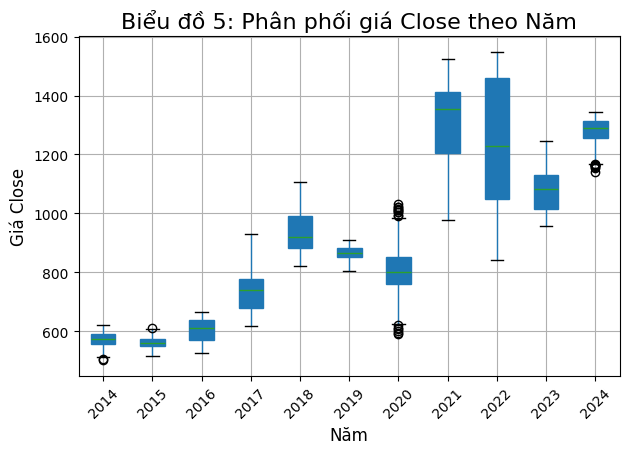

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# --- 1. Tải và chuẩn bị dữ liệu ---
print("Đang tải và xử lý dữ liệu...")
df = pd.read_csv('HOSEVN1001D.csv')

# Chuyển cột 'time' (Unix timestamp) sang dạng datetime
df['time'] = pd.to_datetime(df['time'], unit='s')

# Đặt 'time' làm chỉ mục (index)
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

# Tính toán các cột mới để vẽ biểu đồ
df['Daily_Return'] = df['close'].pct_change()
df['Daily_Spread'] = df['high'] - df['low']
df['Year'] = df.index.year

print(f"Đã tải và xử lý {len(df)} hàng dữ liệu thô.")
print("-" * 30)

# --- 2. Vẽ 5 Biểu đồ ---

# Biểu đồ 1: Giá Close theo thời gian
print("Đang vẽ Biểu đồ 1: Giá Close theo thời gian...")
# Lọc NaN cho cột 'close'
data_plot1 = df.dropna(subset=['close'])
plt.figure(figsize=(12, 6))
plt.plot(data_plot1.index, data_plot1['close'], label='Giá Đóng cửa (Close)')
plt.title('Biểu đồ 1: Giá Đóng cửa (Close) của HOSE VN-Index theo thời gian', fontsize=16)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Giá', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('chart_1_close_price.png')
print("Đã lưu chart_1_close_price.png")


# Biểu đồ 2: Giá Close và các đường EMAs
print("Đang vẽ Biểu đồ 2: Giá Close và các đường EMA...")
# Lọc NaN cho các cột cần thiết cho biểu đồ này
data_plot2 = df.dropna(subset=['close', '55EMA', '89EMA', '200EMA'])
plt.figure(figsize=(14, 7))
plt.plot(data_plot2.index, data_plot2['close'], label='Giá Close', color='blue', alpha=0.8, linewidth=1.5)
plt.plot(data_plot2.index, data_plot2['55EMA'], label='EMA 55 ngày', color='orange', linestyle='--')
plt.plot(data_plot2.index, data_plot2['89EMA'], label='EMA 89 ngày', color='green', linestyle='--')
plt.plot(data_plot2.index, data_plot2['200EMA'], label='EMA 200 ngày', color='red', linestyle='--')
plt.title('Biểu đồ 2: Phân tích Kỹ thuật - Giá Close và các đường EMA', fontsize=16)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Giá', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('chart_2_emas.png')
print("Đã lưu chart_2_emas.png")


# Biểu đồ 3: Phân phối Tỷ suất sinh lợi hàng ngày (Histogram)
print("Đang vẽ Biểu đồ 3: Phân phối Tỷ suất sinh lợi hàng ngày...")
# Lọc NaN cho cột 'Daily_Return'
data_plot3 = df.dropna(subset=['Daily_Return'])
plt.figure(figsize=(10, 6))
# Bỏ qua các giá trị quá lớn (outliers) nếu có
returns_no_outliers_low = data_plot3['Daily_Return'].quantile(0.005)
returns_no_outliers_high = data_plot3['Daily_Return'].quantile(0.995)
# Lọc data trước khi hist
hist_data = data_plot3[(data_plot3['Daily_Return'] > returns_no_outliers_low) & (data_plot3['Daily_Return'] < returns_no_outliers_high)]['Daily_Return']

plt.hist(hist_data, bins=100, alpha=0.75, color='green', edgecolor='black')
plt.title('Biểu đồ 3: Phân phối Tỷ suất sinh lợi hàng ngày', fontsize=16)
plt.xlabel('Tỷ suất sinh lợi (%)', fontsize=12)
plt.ylabel('Tần suất (Số ngày)', fontsize=12)
# Định dạng trục X thành %
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('chart_3_returns_histogram.png')
print("Đã lưu chart_3_returns_histogram.png")


# Biểu đồ 4: Biến động giá trong ngày (High - Low)
print("Đang vẽ Biểu đồ 4: Biến động giá trong ngày (High - Low)...")
# Lọc NaN cho cột 'Daily_Spread'
data_plot4 = df.dropna(subset=['Daily_Spread'])
plt.figure(figsize=(12, 6))
plt.plot(data_plot4.index, data_plot4['Daily_Spread'], label='Biến động (High-Low)', color='purple', alpha=0.7)
plt.title('Biểu đồ 4: Biến động giá trong ngày (High - Low)', fontsize=16)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Chênh lệch giá', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('chart_4_daily_spread.png')
print("Đã lưu chart_4_daily_spread.png")


# Biểu đồ 5: Phân phối giá Close theo Năm (Box Plot)
print("Đang vẽ Biểu đồ 5: Phân phối giá Close theo Năm...")
# Lọc NaN cho cột 'close' và 'Year'
data_plot5 = df.dropna(subset=['close', 'Year']).copy() # Thêm .copy() để tránh warning
# Chuyển đổi 'Year' sang kiểu integer để đảm bảo boxplot hoạt động đúng
data_plot5['Year'] = data_plot5['Year'].astype(int)

if data_plot5.empty:
    print("Không thể vẽ Biểu đồ 5 do thiếu dữ liệu 'close' hoặc 'Year'.")
else:
    plt.figure(figsize=(12, 7))
    # Sử dụng pandas.boxplot
    data_plot5.boxplot(column='close', by='Year', grid=True, patch_artist=True)
    plt.title('Biểu đồ 5: Phân phối giá Close theo Năm', fontsize=16)
    plt.suptitle('') # Xóa tiêu đề phụ mặc định
    plt.xlabel('Năm', fontsize=12)
    plt.ylabel('Giá Close', fontsize=12)
    # Xoay nhãn trục X để dễ đọc
    plt.xticks(rotation=45)
    plt.tight_layout() # Tự động điều chỉnh layout
    plt.savefig('chart_5_box_plot_year.png')
    print("Đã lưu chart_5_box_plot_year.png")

print("-" * 30)
print("Hoàn tất! 5 biểu đồ đã được lưu vào thư mục của bạn.")